In [97]:
"""
LAB 10 - IMAGE COMPRESSION
Complete implementation with Huffman Coding and JPEG-like DCT Compression
"""

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import heapq
from collections import defaultdict, Counter
import pickle
import io

In [98]:
# ============================================================================
# PART 1: HUFFMAN CODING IMPLEMENTATION
# ============================================================================

class HuffmanNode:
    def __init__(self, symbol=None, freq=0, left=None, right=None):
        self.symbol = symbol
        self.freq = freq
        self.left = left
        self.right = right
    
    def __lt__(self, other):
        return self.freq < other.freq

class HuffmanCoding:
    def __init__(self):
        self.codes = {}
        self.reverse_codes = {}
    
    def build_frequency_table(self, data):
        """Build frequency table from data"""
        return Counter(data.flatten())
    
    def build_huffman_tree(self, frequency):
        """Build Huffman tree from frequency table"""
        heap = [HuffmanNode(symbol=sym, freq=freq) for sym, freq in frequency.items()]
        heapq.heapify(heap)
        
        while len(heap) > 1:
            left = heapq.heappop(heap)
            right = heapq.heappop(heap)
            merged = HuffmanNode(freq=left.freq + right.freq, left=left, right=right)
            heapq.heappush(heap, merged)
        
        return heap[0] if heap else None
    
    def generate_codes(self, node, code=""):
        """Generate Huffman codes from tree"""
        if node is None:
            return
        
        if node.symbol is not None:
            self.codes[node.symbol] = code if code else "0"
            self.reverse_codes[code if code else "0"] = node.symbol
            return
        
        self.generate_codes(node.left, code + "0")
        self.generate_codes(node.right, code + "1")
    
    def encode(self, data):
        """Encode data using Huffman coding"""
        frequency = self.build_frequency_table(data)
        root = self.build_huffman_tree(frequency)
        self.generate_codes(root)
        
        # Encode the data
        encoded = ''.join([self.codes[pixel] for pixel in data.flatten()])
        
        return encoded, self.codes, data.shape
    
    def decode(self, encoded_data, codes, shape):
        """Decode Huffman encoded data"""
        self.reverse_codes = {v: k for k, v in codes.items()}
        
        decoded = []
        current_code = ""
        
        for bit in encoded_data:
            current_code += bit
            if current_code in self.reverse_codes:
                decoded.append(self.reverse_codes[current_code])
                current_code = ""
        
        return np.array(decoded).reshape(shape)

In [99]:
# ============================================================================
# PART 2: JPEG-LIKE DCT COMPRESSION
# ============================================================================

class DCTCompression:
    def __init__(self, block_size=8):
        self.block_size = block_size
        # Standard JPEG quantization matrix
        self.quantization_matrix = np.array([
            [16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]
        ])
    
    def dct2d(self, block):
        """2D Discrete Cosine Transform"""
        return np.round(np.fft.fft2(block).real)
    
    def idct2d(self, block):
        """2D Inverse Discrete Cosine Transform"""
        return np.round(np.fft.ifft2(block).real)
    
    def better_dct2d(self, block):
        """Better 2D DCT using separable property"""
        from scipy.fftpack import dct, idct
        return dct(dct(block.T, norm='ortho').T, norm='ortho')
    
    def better_idct2d(self, block):
        """Better 2D IDCT using separable property"""
        from scipy.fftpack import dct, idct
        return idct(idct(block.T, norm='ortho').T, norm='ortho')
    
    def compress(self, image, quality_factor=50):
        """Compress image using DCT"""
        # Try to import scipy for better DCT, fallback to numpy
        try:
            from scipy.fftpack import dct, idct
            use_scipy = True
        except ImportError:
            use_scipy = False
            print("Warning: scipy not available, using numpy FFT-based DCT")
        
        h, w = image.shape
        
        # Pad image to make it divisible by block_size
        pad_h = (self.block_size - h % self.block_size) % self.block_size
        pad_w = (self.block_size - w % self.block_size) % self.block_size
        padded = np.pad(image, ((0, pad_h), (0, pad_w)), mode='edge')
        
        # Adjust quantization matrix based on quality
        scale = 50 / quality_factor if quality_factor < 50 else (100 - quality_factor) / 50
        quant_matrix = np.maximum(self.quantization_matrix * scale, 1)
        
        compressed = np.zeros_like(padded, dtype=float)
        
        # Process each block
        for i in range(0, padded.shape[0], self.block_size):
            for j in range(0, padded.shape[1], self.block_size):
                block = padded[i:i+self.block_size, j:j+self.block_size].astype(float)
                
                # Apply DCT
                if use_scipy:
                    dct_block = self.better_dct2d(block)
                else:
                    dct_block = self.dct2d(block)
                
                # Quantize
                quantized = np.round(dct_block / quant_matrix)
                compressed[i:i+self.block_size, j:j+self.block_size] = quantized
        
        return compressed, quant_matrix, (h, w), use_scipy
    
    def decompress(self, compressed, quant_matrix, original_shape, use_scipy=True):
        """Decompress DCT compressed image"""
        decompressed = np.zeros_like(compressed, dtype=float)
        
        # Process each block
        for i in range(0, compressed.shape[0], self.block_size):
            for j in range(0, compressed.shape[1], self.block_size):
                quantized = compressed[i:i+self.block_size, j:j+self.block_size]
                
                # Dequantize
                dct_block = quantized * quant_matrix
                
                # Apply IDCT
                if use_scipy:
                    block = self.better_idct2d(dct_block)
                else:
                    block = self.idct2d(dct_block)
                
                decompressed[i:i+self.block_size, j:j+self.block_size] = block
        
        # Remove padding
        h, w = original_shape
        return np.clip(decompressed[:h, :w], 0, 255).astype(np.uint8)


In [100]:
# ============================================================================
# PART 3: METRICS CALCULATION
# ============================================================================

def calculate_compression_ratio(original_size, compressed_size):
    """Calculate Compression Ratio"""
    return original_size / compressed_size

def calculate_mse(original, compressed):
    """Calculate Mean Squared Error"""
    return np.mean((original.astype(float) - compressed.astype(float)) ** 2)

def calculate_psnr(original, compressed):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = calculate_mse(original, compressed)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_rd(original, compressed, compressed_size):
    """Calculate Rate-Distortion (bits per pixel vs MSE)"""
    rate = compressed_size * 8 / (original.shape[0] * original.shape[1])  # bits per pixel
    distortion = calculate_mse(original, compressed)
    return rate, distortion

In [101]:

# ============================================================================
# PART 4: MAIN COMPRESSION PIPELINE
# ============================================================================

def load_image(image_path):
    """Load and convert image to grayscale"""
    img = Image.open(image_path).convert('L')
    return np.array(img)

def get_compressed_size_huffman(encoded_bits, codes):
    """Calculate compressed size for Huffman coding"""
    # Size of encoded data in bytes
    encoded_bytes = len(encoded_bits) // 8 + (1 if len(encoded_bits) % 8 else 0)
    
    # Size of codebook (assuming each symbol is 1 byte and code length is stored)
    codebook_size = len(codes) * 3  # symbol (1 byte) + code length (2 bytes)
    
    return encoded_bytes + codebook_size

def get_compressed_size_dct(compressed_data):
    """Calculate compressed size for DCT compression"""
    # Use pickle to serialize and get size
    buffer = io.BytesIO()
    np.save(buffer, compressed_data)
    return buffer.tell()

def compress_and_compare(image_path, dct_quality=50):
    """Main function to compress image and compare results"""
    print("="*80)
    print("LAB 10 - IMAGE COMPRESSION")
    print("="*80)
    
    # Load image
    print(f"\n1. Loading image: {image_path}")
    original = load_image(image_path)
    print(f"   Image shape: {original.shape}")
    print(f"   Original size: {original.nbytes} bytes")

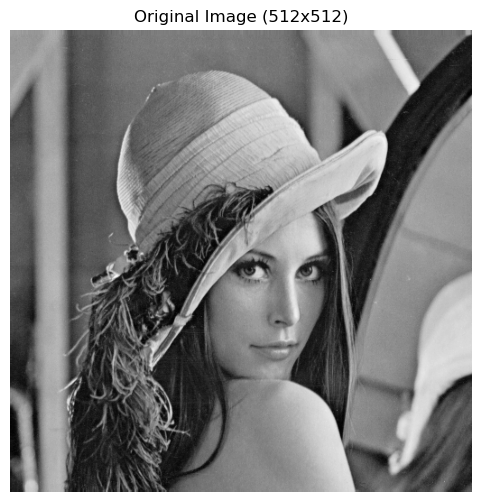

Image loaded successfully!
Shape: (512, 512)
Size: 262144 bytes


In [102]:
# ========================================
# CHANGE THIS LINE TO YOUR IMAGE PATH
# ========================================
image_path = 'C:/Users/bushr/Desktop/LENA-TASK-10-IMG.png'  # <-- Update this!

# Load and display the image
original = np.array(Image.open(image_path).convert('L'))

plt.figure(figsize=(8, 6))
plt.imshow(original, cmap='gray')
plt.title(f'Original Image ({original.shape[0]}x{original.shape[1]})')
plt.axis('off')
plt.show()

print(f"Image loaded successfully!")
print(f"Shape: {original.shape}")
print(f"Size: {original.nbytes} bytes")

In [103]:
# ========================================================================
    # HUFFMAN CODING COMPRESSION
    # ========================================================================
print("\n" + "="*80)
print("HUFFMAN CODING COMPRESSION")
print("="*80)
    
huffman = HuffmanCoding()
encoded_bits, codes, shape = huffman.encode(original)
compressed_huffman = huffman.decode(encoded_bits, codes, shape)
    
huffman_size = get_compressed_size_huffman(encoded_bits, codes)
huffman_cr = calculate_compression_ratio(original.nbytes, huffman_size)
huffman_mse = calculate_mse(original, compressed_huffman)
huffman_psnr = calculate_psnr(original, compressed_huffman)
huffman_rate, huffman_distortion = calculate_rd(original, compressed_huffman, huffman_size)
    
print(f"\nResults:")
print(f"  Compressed size: {huffman_size} bytes")
print(f"  Compression Ratio (CR): {huffman_cr:.2f}")
print(f"  Mean Squared Error (MSE): {huffman_mse:.4f}")
print(f"  Peak Signal-to-Noise Ratio (PSNR): {huffman_psnr:.2f} dB")
print(f"  Rate-Distortion: {huffman_rate:.4f} bits/pixel, Distortion: {huffman_distortion:.4f}")


HUFFMAN CODING COMPRESSION

Results:
  Compressed size: 245342 bytes
  Compression Ratio (CR): 1.07
  Mean Squared Error (MSE): 0.0000
  Peak Signal-to-Noise Ratio (PSNR): inf dB
  Rate-Distortion: 7.4872 bits/pixel, Distortion: 0.0000


In [104]:
# ========================================================================
    # DCT (JPEG-LIKE) COMPRESSION
    # ========================================================================
dct_quality = 50 
print("\n" + "="*80)
print(f"DCT (JPEG-LIKE) COMPRESSION (Quality: {dct_quality})")
print("="*80)
    
dct = DCTCompression()
compressed_dct, quant_matrix, orig_shape, use_scipy = dct.compress(original, quality_factor=dct_quality)
decompressed_dct = dct.decompress(compressed_dct, quant_matrix, orig_shape, use_scipy)
    
dct_size = get_compressed_size_dct(compressed_dct)
dct_cr = calculate_compression_ratio(original.nbytes, dct_size)
dct_mse = calculate_mse(original, decompressed_dct)
dct_psnr = calculate_psnr(original, decompressed_dct)
dct_rate, dct_distortion = calculate_rd(original, decompressed_dct, dct_size)
    
print(f"\nResults:")
print(f"  Compressed size: {dct_size} bytes")
print(f"  Compression Ratio (CR): {dct_cr:.2f}")
print(f"  Mean Squared Error (MSE): {dct_mse:.4f}")
print(f"  Peak Signal-to-Noise Ratio (PSNR): {dct_psnr:.2f} dB")
print(f"  Rate-Distortion: {dct_rate:.4f} bits/pixel, Distortion: {dct_distortion:.4f}")
    


DCT (JPEG-LIKE) COMPRESSION (Quality: 50)

Results:
  Compressed size: 2097280 bytes
  Compression Ratio (CR): 0.12
  Mean Squared Error (MSE): 17.3042
  Peak Signal-to-Noise Ratio (PSNR): 35.75 dB
  Rate-Distortion: 64.0039 bits/pixel, Distortion: 17.3042


In [105]:
 # ========================================================================
    # COMPARISON AND VISUALIZATION
    # ========================================================================
print("\n" + "="*80)
print("COMPARISON SUMMARY")
print("="*80)
    
print(f"\n{'Metric':<30} {'Huffman':<20} {'DCT (JPEG-like)':<20}")
print("-"*70)
print(f"{'Compression Ratio':<30} {huffman_cr:<20.2f} {dct_cr:<20.2f}")
print(f"{'MSE':<30} {huffman_mse:<20.4f} {dct_mse:<20.4f}")
print(f"{'PSNR (dB)':<30} {huffman_psnr:<20.2f} {dct_psnr:<20.2f}")
print(f"{'Rate (bits/pixel)':<30} {huffman_rate:<20.4f} {dct_rate:<20.4f}")
    


COMPARISON SUMMARY

Metric                         Huffman              DCT (JPEG-like)     
----------------------------------------------------------------------
Compression Ratio              1.07                 0.12                
MSE                            0.0000               17.3042             
PSNR (dB)                      inf                  35.75               
Rate (bits/pixel)              7.4872               64.0039             


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

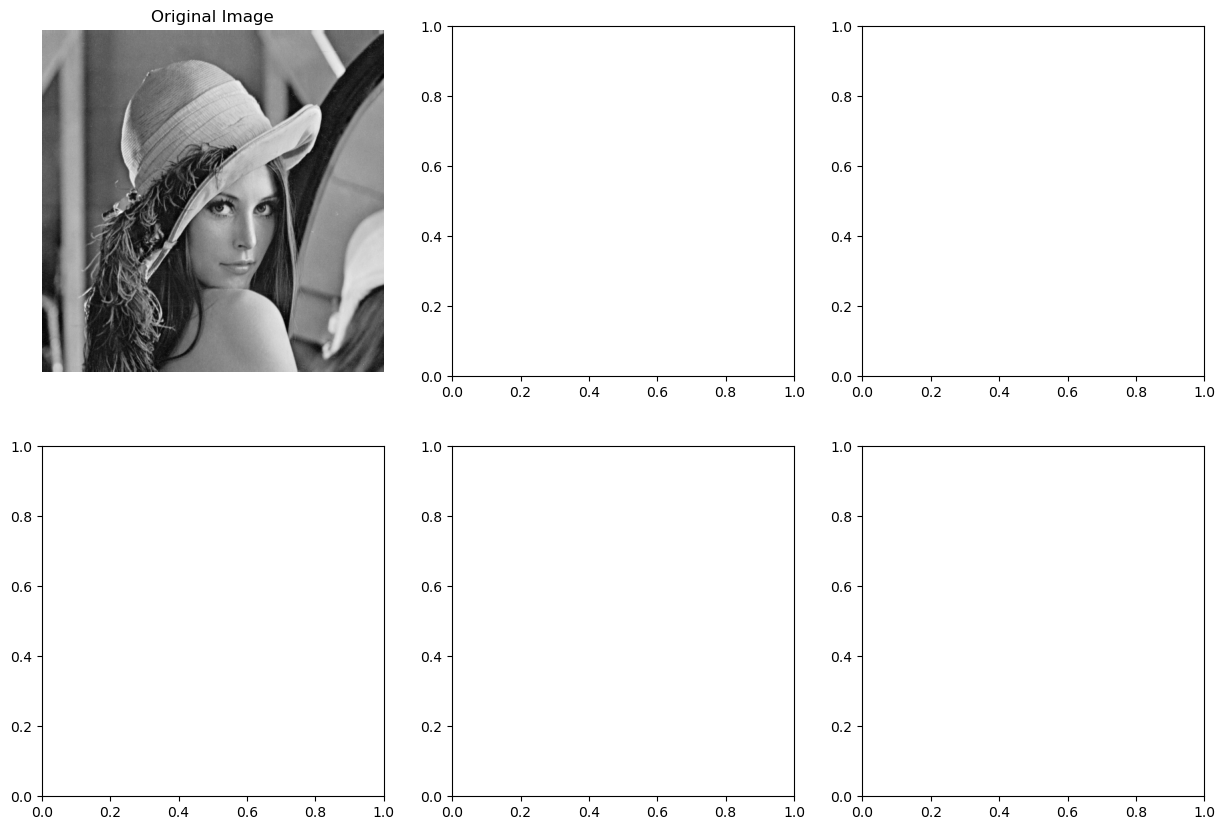

In [106]:
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

In [107]:
   # Original image
axes[0, 0].imshow(original, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

In [108]:
   # Huffman compressed
axes[0, 1].imshow(compressed_huffman, cmap='gray')
axes[0, 1].set_title(f'Huffman Compressed\nCR: {huffman_cr:.2f}, PSNR: {huffman_psnr:.2f} dB')
axes[0, 1].axis('off')

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

In [109]:
   # Huffman difference
diff_huffman = np.abs(original.astype(float) - compressed_huffman.astype(float))
axes[0, 2].imshow(diff_huffman, cmap='hot')
axes[0, 2].set_title(f'Huffman Difference\nMSE: {huffman_mse:.4f}')
axes[0, 2].axis('off')

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

In [110]:
    # DCT compressed
axes[1, 1].imshow(decompressed_dct, cmap='gray')
axes[1, 1].set_title(f'DCT Compressed (Q={dct_quality})\nCR: {dct_cr:.2f}, PSNR: {dct_psnr:.2f} dB')
axes[1, 1].axis('off')

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

In [111]:
   # DCT difference
diff_dct = np.abs(original.astype(float) - decompressed_dct.astype(float))
axes[1, 2].imshow(diff_dct, cmap='hot')
axes[1, 2].set_title(f'DCT Difference\nMSE: {dct_mse:.4f}')
axes[1, 2].axis('off')

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

In [112]:
    # Histogram comparison
axes[1, 0].hist(original.flatten(), bins=50, alpha=0.5, label='Original', color='blue')
axes[1, 0].hist(decompressed_dct.flatten(), bins=50, alpha=0.5, label='DCT', color='red')
axes[1, 0].set_title('Pixel Value Distribution')
axes[1, 0].set_xlabel('Pixel Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
plt.tight_layout()
plt.savefig('compression_results.png', dpi=150, bbox_inches='tight')
print(f"\n📊 Visualization saved as 'compression_results.png'")
plt.show()


📊 Visualization saved as 'compression_results.png'


<Figure size 640x480 with 0 Axes>

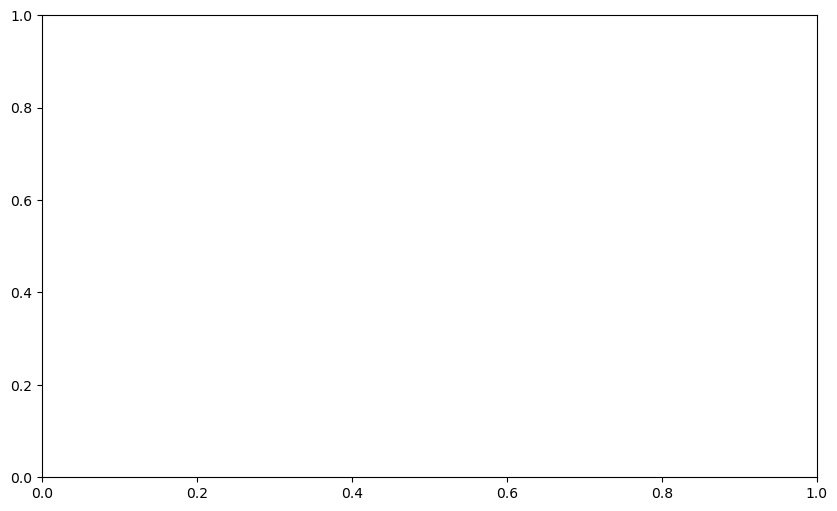

In [113]:
  # Rate-Distortion curve
fig2, ax = plt.subplots(1, 1, figsize=(10, 6))

Computing Rate-Distortion curve...
  Quality 10: Rate=64.00 bpp, PSNR=30.40 dB
  Quality 20: Rate=64.00 bpp, PSNR=32.94 dB
  Quality 30: Rate=64.00 bpp, PSNR=34.23 dB
  Quality 40: Rate=64.00 bpp, PSNR=35.10 dB
  Quality 50: Rate=64.00 bpp, PSNR=35.75 dB
  Quality 60: Rate=64.00 bpp, PSNR=36.39 dB
  Quality 70: Rate=64.00 bpp, PSNR=37.24 dB
  Quality 80: Rate=64.00 bpp, PSNR=38.43 dB
  Quality 90: Rate=64.00 bpp, PSNR=40.61 dB

📈 Rate-Distortion curve saved as 'rate_distortion_curve.png'


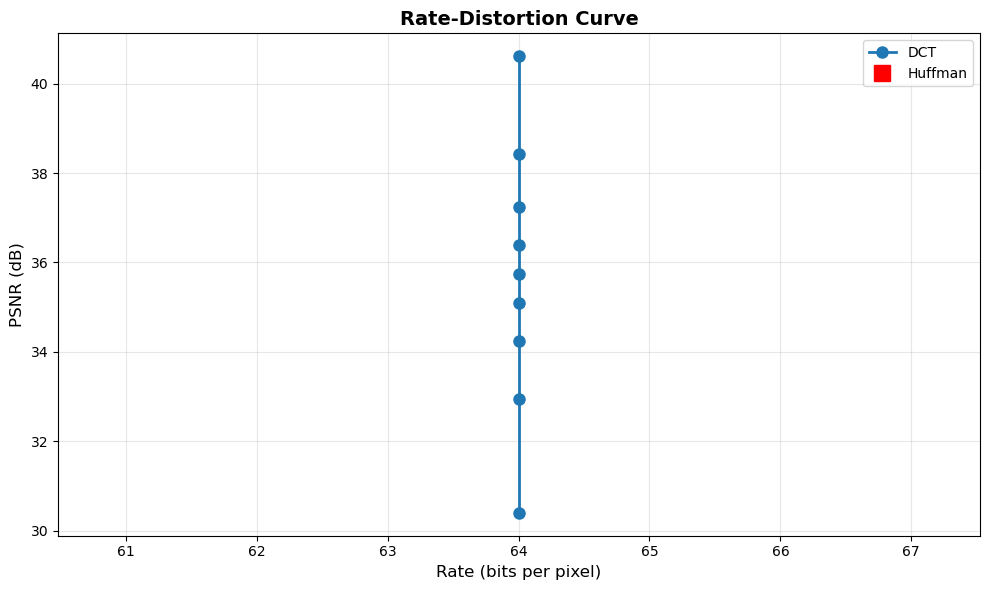


LAB 10 COMPLETED SUCCESSFULLY!


In [114]:
# Test multiple quality factors for DCT
qualities = [10, 20, 30, 40, 50, 60, 70, 80, 90]
rates = []
distortions = []
psnrs = []

print("Computing Rate-Distortion curve...")
for q in qualities:
    comp_dct, qm, os, us = dct.compress(original, quality_factor=q)  # ✅ 4 variables
    decomp_dct = dct.decompress(comp_dct, qm, os, us)  # ✅ 4 parameters
    size = get_compressed_size_dct(comp_dct)
    rate, dist = calculate_rd(original, decomp_dct, size)
    psnr = calculate_psnr(original, decomp_dct)
    rates.append(rate)
    distortions.append(dist)
    psnrs.append(psnr)
    print(f"  Quality {q}: Rate={rate:.2f} bpp, PSNR={psnr:.2f} dB")

fig2, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(rates, psnrs, 'o-', linewidth=2, markersize=8, label='DCT')
ax.plot([huffman_rate], [huffman_psnr], 's', markersize=12, label='Huffman', color='red')
ax.set_xlabel('Rate (bits per pixel)', fontsize=12)
ax.set_ylabel('PSNR (dB)', fontsize=12)
ax.set_title('Rate-Distortion Curve', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('rate_distortion_curve.png', dpi=150, bbox_inches='tight')
print(f"\n📈 Rate-Distortion curve saved as 'rate_distortion_curve.png'")
plt.show()

print("\n" + "="*80)
print("LAB 10 COMPLETED SUCCESSFULLY!")
print("="*80)